In [15]:
import pandas as pd
import time
import numpy as np
#from sklearn.cross_validation import train_test_split
import xgboost as xgb
import copy
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn import metrics




## Commons function definition




***




In [16]:
def buildROC(target_test,test_preds):
    """ plot roc curve """
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.axis('equal')
    plt.axis([0, 1, 0, 1])
    #plt.gcf().savefig('roc.png')
    


## data load

load data into pandas


***


In [21]:
path = './data/'

application_train = pd.read_csv(path + "application_train.csv" )#,nrows=10000) #, skiprows=1, nrows=40000
application_test = pd.read_csv(path + "application_test.csv" )#,nrows=10000) #, skiprows=1, nrows=40000


In [23]:
application_train.head()


application_train.describe() #(include='all')

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [28]:

#print(np.divide( np.sum(application_train.TARGET), application_train.shape[0])*100)
#application_train.hist("TARGET")

In [29]:
#application_train = application_train[application_train['SK_ID_CURR'].apply(lambda x: type(x) in [int, np.int64, float, np.float64])]

application_train = application_train.select_dtypes(include=["int","bool","float"])
application_test = application_test.select_dtypes(include=["int","bool","float"])

application_test.shape

(48744, 105)

In [197]:


y = application_train["TARGET"]
X = application_train.drop(["TARGET","SK_ID_CURR"], axis=1)

amountTrue = sum(y)/len(y)
amountFalse = 1 - amountTrue

def weightFun(x):
    if x==0:
        return 1/amountFalse
    else:
        return 1/amountTrue

weights=list(map(weightFun,y))

weights = np.array(weights)


#application_train2=application_train.sub(means)
def zNormPandas(X):
    means = X.mean()
    standarDev = X.std()
    X=X.sub(means)
    return X.div(standarDev)


X = zNormPandas(X)

if False:
    train_X = X
    train_y = y
    test_X = X
    test_y = y
    dtrain = xgb.DMatrix(train_X,label=train_y)
    dtest = xgb.DMatrix(test_X)  
else:
    train_index = np.random.choice(len(X), round(len(X) * 0.7), replace=False)
    test_index = np.array(list(set(range(len(X))) - set(train_index)))

    train_X = X.iloc[train_index]
    weights_X = weights[train_index]
    train_y = y.iloc[train_index]
    test_X = X.iloc[test_index]
    test_y = y.iloc[test_index]

    dtrain = xgb.DMatrix(train_X,label=train_y,weight=weights_X)
    dtest = xgb.DMatrix(test_X)    

train_X.describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,215258.000000,215258.000000,215258.000000,215249.000000,215049.000000,215258.000000,215258.000000,215258.000000,215258.000000,215258.000000,...,215258.000000,215258.000000,215258.000000,215258.000000,186113.000000,186113.000000,186113.000000,186113.000000,186113.000000,186113.000000
mean,0.000266,0.000190,-0.000803,-0.000853,-0.001009,0.002592,-0.000941,0.001829,-0.001995,-0.001291,...,-0.000207,-0.001353,-0.000041,0.000482,-0.000550,0.001755,0.000021,-0.000468,-0.002424,-0.000054
std,1.002014,1.161607,0.999934,0.997353,0.999576,1.003800,1.000840,1.001518,1.001524,1.001086,...,0.998866,0.971908,0.999084,1.013086,0.998083,1.031116,1.001081,0.999040,0.769353,0.999724
min,-0.577537,-0.603686,-1.376494,-1.758903,-1.347682,-1.487795,-2.099915,-0.578493,-5.322874,-2.356353,...,-0.090534,-0.024402,-0.022529,-0.018305,-0.076357,-0.063203,-0.167877,-0.291915,-0.334327,-1.016412
25%,-0.577537,-0.237421,-0.817475,-0.731528,-0.811745,-0.785329,-0.837939,-0.471213,-0.710463,-0.865744,...,-0.090534,-0.024402,-0.022529,-0.018305,-0.076357,-0.063203,-0.167877,-0.291915,-0.334327,-1.016412
50%,-0.577537,-0.094463,-0.213734,-0.151243,-0.239267,-0.145909,0.064619,-0.460277,0.136286,-0.176089,...,-0.090534,-0.024402,-0.022529,-0.018305,-0.076357,-0.063203,-0.167877,-0.291915,-0.334327,-0.481451
75%,0.807272,0.142129,0.520817,0.516597,0.381933,0.563570,0.830432,-0.453737,0.841674,0.844812,...,-0.090534,-0.024402,-0.022529,-0.018305,-0.076357,-0.063203,-0.167877,-0.291915,-0.334327,0.588471
max,25.733829,492.702648,8.574045,15.932187,9.505041,3.733558,1.958757,2.133614,1.415351,1.983637,...,11.045542,40.980270,44.387137,54.630889,35.702190,81.195471,38.916593,29.183990,9.740534,11.287692


215258

[12.387150050352467,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860134566,
 12.387150050352467,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860134566,
 12.387150050352467,
 1.0878182860134566,
 12.387150050352467,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860134566,
 1.0878182860

In [87]:
print(np.divide( np.sum(train_y), train_y.shape[0])*100)
print(np.divide( np.sum(test_y), test_y.shape[0])*100)


8.072881945686495
8.072881945686495


[0]	train-auc:0.69448	train-error:0.350865	valid-auc:0.682337	valid-error:0.292717
[1]	train-auc:0.70803	train-error:0.342538	valid-auc:0.696331	valid-error:0.360389
[2]	train-auc:0.715611	train-error:0.339792	valid-auc:0.704488	valid-error:0.323784
[3]	train-auc:0.721691	train-error:0.33457	valid-auc:0.710427	valid-error:0.353105
[4]	train-auc:0.724052	train-error:0.334202	valid-auc:0.71204	valid-error:0.351587
[5]	train-auc:0.726933	train-error:0.331951	valid-auc:0.714852	valid-error:0.350341
[6]	train-auc:0.731293	train-error:0.329929	valid-auc:0.719207	valid-error:0.333843
[7]	train-auc:0.735765	train-error:0.32606	valid-auc:0.7227	valid-error:0.331501
[8]	train-auc:0.738043	train-error:0.323935	valid-auc:0.725248	valid-error:0.33097
[9]	train-auc:0.739596	train-error:0.323621	valid-auc:0.726599	valid-error:0.329637
[10]	train-auc:0.741939	train-error:0.320857	valid-auc:0.728257	valid-error:0.327371
[11]	train-auc:0.742714	train-error:0.320713	valid-auc:0.729096	valid-error:0.32252

[98]	train-auc:0.776187	train-error:0.295653	valid-auc:0.744906	valid-error:0.304272
[99]	train-auc:0.776383	train-error:0.295603	valid-auc:0.745055	valid-error:0.304424
[100]	train-auc:0.77668	train-error:0.295412	valid-auc:0.745181	valid-error:0.303849
[101]	train-auc:0.776903	train-error:0.295079	valid-auc:0.745113	valid-error:0.303806
[102]	train-auc:0.777056	train-error:0.294751	valid-auc:0.745138	valid-error:0.30373
[103]	train-auc:0.777336	train-error:0.294832	valid-auc:0.74512	valid-error:0.30386
[104]	train-auc:0.777546	train-error:0.294586	valid-auc:0.745063	valid-error:0.304066
[105]	train-auc:0.777722	train-error:0.294451	valid-auc:0.745053	valid-error:0.303578
[106]	train-auc:0.777892	train-error:0.294169	valid-auc:0.744929	valid-error:0.303394
[107]	train-auc:0.778084	train-error:0.294192	valid-auc:0.744896	valid-error:0.303426
[108]	train-auc:0.778269	train-error:0.294139	valid-auc:0.744794	valid-error:0.303361
[109]	train-auc:0.77854	train-error:0.293722	valid-auc:0.744

[194]	train-auc:0.793034	train-error:0.28244	valid-auc:0.745084	valid-error:0.297432
[195]	train-auc:0.793148	train-error:0.282384	valid-auc:0.745093	valid-error:0.297595
[196]	train-auc:0.793335	train-error:0.282161	valid-auc:0.744959	valid-error:0.297627
[197]	train-auc:0.793473	train-error:0.281981	valid-auc:0.744879	valid-error:0.297876
[198]	train-auc:0.793632	train-error:0.28175	valid-auc:0.744783	valid-error:0.297356
[199]	train-auc:0.793696	train-error:0.281933	valid-auc:0.744732	valid-error:0.2974
[200]	train-auc:0.793801	train-error:0.281691	valid-auc:0.744763	valid-error:0.296966
[201]	train-auc:0.793953	train-error:0.281342	valid-auc:0.74481	valid-error:0.297269
[202]	train-auc:0.794069	train-error:0.281543	valid-auc:0.744724	valid-error:0.296836
[203]	train-auc:0.794173	train-error:0.281468	valid-auc:0.744792	valid-error:0.296793
[204]	train-auc:0.794449	train-error:0.281172	valid-auc:0.744828	valid-error:0.296597
[205]	train-auc:0.794509	train-error:0.281126	valid-auc:0.7

[290]	train-auc:0.806369	train-error:0.271476	valid-auc:0.743144	valid-error:0.292229
[291]	train-auc:0.806479	train-error:0.271289	valid-auc:0.743093	valid-error:0.292511
[292]	train-auc:0.806594	train-error:0.270981	valid-auc:0.743076	valid-error:0.292337
[293]	train-auc:0.806664	train-error:0.271095	valid-auc:0.743014	valid-error:0.292522
[294]	train-auc:0.806773	train-error:0.270976	valid-auc:0.743006	valid-error:0.292533
[295]	train-auc:0.806835	train-error:0.270639	valid-auc:0.743014	valid-error:0.292825
[296]	train-auc:0.806981	train-error:0.270298	valid-auc:0.743018	valid-error:0.292327
[297]	train-auc:0.807116	train-error:0.270074	valid-auc:0.743026	valid-error:0.292316
[298]	train-auc:0.807282	train-error:0.27005	valid-auc:0.743036	valid-error:0.292381
[299]	train-auc:0.807385	train-error:0.270201	valid-auc:0.742966	valid-error:0.292327
[300]	train-auc:0.807504	train-error:0.270015	valid-auc:0.74305	valid-error:0.291958
[301]	train-auc:0.807624	train-error:0.269909	valid-auc:

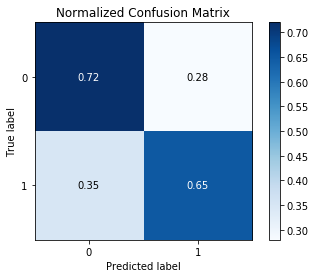

In [199]:

param = { 'max_depth': 3,
          'learning_rate':0.3,
          'subsample': 0.9, 
          'colsample_bytree': 0.9, 
          'colsample_bylevel':0.9,
          'min_child_weight':10,
          'scale_pos_weight': 1, #0.1
          'alpha':10,
          'objective': 'binary:logistic', 
          'eval_metric': 'auc', 
          'random_state': 99,          
          'nthread': 4,
          'n_jobs': 4,
          'silent': False}

param_old = {'max_depth':10,
         'eta':0.5, 
         'silent':0, 
         'objective':'binary:logistic',
         'scale_pos_weight': 0.1 ,
         'nthread': 4,
         'eval_metric': 'auc'}

num_round = 350
param['eval_metric'] = ['auc', 'error']

evallist = [ (dtrain, 'train')]

watchlist = [(dtrain, 'train'), (xgb.DMatrix(test_X,label=test_y), 'valid')]

bst = xgb.train(param, dtrain, num_round, watchlist)

pred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)
#pred = np.round(pred)


ypred = np.round(pred)

print( sum(test_y==pred)/len(pred)*100 )

skplt.metrics.plot_confusion_matrix(test_y, ypred, normalize=True)
plt.show()

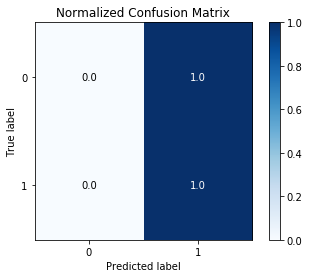

In [9]:

ypred = np.round(pred+0.49999)
skplt.metrics.plot_confusion_matrix(test_y, ypred , normalize=True)
plt.show()


In [10]:
ypred.shape


(15376,)

In [11]:

ypred = np.float32(np.ones((len(pred),1))[pred > 0.5])


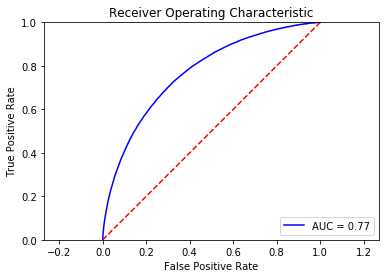

In [92]:
buildROC(test_y,pred)

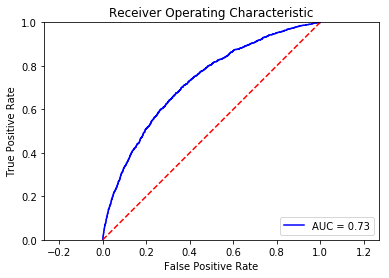

In [14]:
buildROC(test_y,pred)

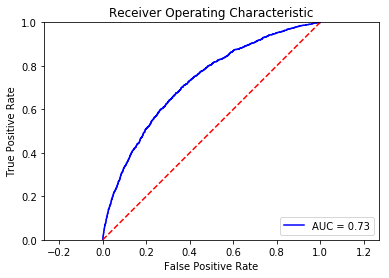

In [15]:
buildROC(test_y,pred)

In [16]:
len(test_y)

15376

In [93]:
submitTest = xgb.DMatrix(application_test.drop(["SK_ID_CURR"], axis=1))
submit = bst.predict(submitTest, ntree_limit=bst.best_ntree_limit)


In [94]:
print(submit.shape)
print(application_test.SK_ID_CURR.shape)
skId=application_test.SK_ID_CURR.values
print(skId)

(48744,)
(48744,)
[100001 100005 100013 ... 456223 456224 456250]


In [95]:
#dataToSubmit=np.array([ np.array([submit,submit]), skId ])
#SK_ID_CURR,TARGET

data ={'SK_ID_CURR': skId, 
        'TARGET': submit}

df = pd.DataFrame( data)


In [96]:
#df = pd.DataFrame( np.array([submit,submit]),index=skId)
#sub.to_csv('xgb_sub.csv',index=False)
df.to_csv('xgb_sub_3.csv',index=False)

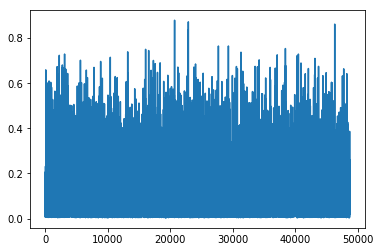

In [21]:
plt.plot(submit)

In [113]:
means = application_train.mean()
standarDev = application_train.std()
standarDev

SK_ID_CURR                     102790.175348
TARGET                              0.272419
CNT_CHILDREN                        0.722121
AMT_INCOME_TOTAL               237123.146279
AMT_CREDIT                     402490.776996
AMT_ANNUITY                     14493.737315
AMT_GOODS_PRICE                369446.460540
REGION_POPULATION_RELATIVE          0.013831
DAYS_BIRTH                       4363.988632
DAYS_EMPLOYED                  141275.766519
DAYS_REGISTRATION                3522.886321
DAYS_ID_PUBLISH                  1509.450419
OWN_CAR_AGE                        11.944812
FLAG_MOBIL                          0.001803
FLAG_EMP_PHONE                      0.384280
FLAG_WORK_PHONE                     0.399526
FLAG_CONT_MOBILE                    0.043164
FLAG_PHONE                          0.449521
FLAG_EMAIL                          0.231307
CNT_FAM_MEMBERS                     0.910682
REGION_RATING_CLIENT                0.509034
REGION_RATING_CLIENT_W_CITY         0.502737
HOUR_APPR_

In [125]:
application_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [129]:

U=zNormPandas(application_train)
U.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.074990e+05,3.072330e+05,3.075110e+05,3.075110e+05,3.075110e+05,...,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,2.659920e+05,2.659920e+05,2.659920e+05,2.659920e+05,2.659920e+05,2.659920e+05
mean,-1.395629e-15,5.671413e-15,9.417243e-17,-6.965472e-16,-4.517056e-17,1.088990e-16,-1.863186e-16,-6.814108e-13,2.127156e-17,-7.200268e-16,...,4.429859e-16,-6.476537e-15,2.102168e-15,-5.783653e-15,-9.800230e-16,5.673674e-15,5.808311e-15,-1.083271e-15,3.647811e-15,2.094114e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.733420e+00,-2.963410e-01,-5.775369e-01,-6.036860e-01,-1.376494e+00,-1.758903e+00,-1.347682e+00,-1.487795e+00,-2.106331e+00,-5.784930e-01,...,-9.053397e-02,-2.440191e-02,-2.252898e-02,-1.830460e-02,-7.635676e-02,-6.320309e-02,-1.678773e-01,-2.919155e-01,-3.343269e-01,-1.016412e+00
25%,-8.661822e-01,-2.963410e-01,-5.775369e-01,-2.374206e-01,-8.174746e-01,-7.302860e-01,-8.117447e-01,-7.853295e-01,-8.352462e-01,-4.712418e-01,...,-9.053397e-02,-2.440191e-02,-2.252898e-02,-1.830460e-02,-7.635676e-02,-6.320309e-02,-1.678773e-01,-2.919155e-01,-3.343269e-01,-1.016412e+00
50%,2.089832e-04,-2.963410e-01,-5.775369e-01,-9.129399e-02,-2.124148e-01,-1.521743e-01,-2.392666e-01,-1.459093e-01,6.576439e-02,-4.602916e-01,...,-9.053397e-02,-2.440191e-02,-2.252898e-02,-1.830460e-02,-7.635676e-02,-6.320309e-02,-1.678773e-01,-2.919155e-01,-3.343269e-01,-4.814513e-01
75%,8.654716e-01,-2.963410e-01,8.072718e-01,1.421290e-01,5.208169e-01,5.165973e-01,3.819330e-01,5.635695e-01,8.304318e-01,-4.537512e-01,...,-9.053397e-02,-2.440191e-02,-2.252898e-02,-1.830460e-02,-7.635676e-02,-6.320309e-02,-1.678773e-01,-2.919155e-01,-3.343269e-01,5.884708e-01
max,1.732408e+00,3.374480e+00,2.573383e+01,4.927026e+02,8.574045e+00,1.593219e+01,9.505041e+00,3.733558e+00,1.958757e+00,2.133614e+00,...,1.104554e+01,4.098027e+01,4.438714e+01,5.463089e+01,4.762837e+01,8.119547e+01,3.891659e+01,2.918399e+01,3.283580e+02,1.235761e+01
